# Преффиксное дерево
Существует две наиболее универсальные структуры данных для хранения произвольных объектов -- это хэш-таблицы и бинарные деревья поиска. Для хранения строк с целью какого-либо последующего поиска интересны графовые структуры, вот например

In [1]:
from graph_utils.graph import Node, Arc, Graph
from animation_utils.animation import animate_list, animate_dict

In [2]:
def simple_tree(words):
    arcs = []
    root = 0
    state = 1
    for word in words:
        prev = root
        for letter in word:
            arcs.append(Arc(prev, state, letter))
            prev = state
            state += 1
    return Graph(arcs)        

In [3]:
words = [
    'мама',
    'мыла',
    'раму',
    'мылом',
]

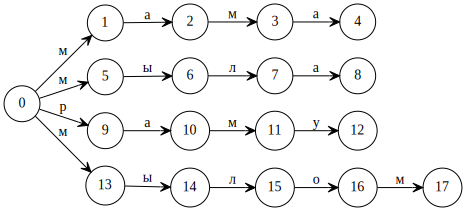

In [4]:
simple_tree(words).Visualize()

Каждому слову в списке соответствует путь в этом графе из $0$ до некоторого листа и наоборот, конкатенируя символы, написанные на переходах мы получаем исходные слова. Само по себе это дерево не имеет ценности, зато имеет его более компактный вариант -- преффиксное дерево. Ключевое соображение заключается в следующем: вершины $1, 5, 13$ можно объединить, так как переходы $0\rightarrow 1, 0\rightarrow 5, 0\rightarrow 13$ помечены одним и тем же символом, после такого объединения набор строк на путях от корня к листьям не поменяется. Если попробовать выжать как можно больше из этого соображения, то мы получим <i><b>преффиксное дерево</b> (trie, prefix tree)</i>.

In [5]:
class TrieNode:
    def __init__(self, parent, word=None):
        self.parent = parent
        self.word = word
        self.children = {}
        self.suff_link = None

In [6]:
def init_trie():
    trie = [TrieNode(-1)]
    return trie

In [7]:
def add_word(trie, word):
    _num = 0
    for ch in word:
        if not ch in trie[_num].children:
            _n = len(trie)
            trie[_num].children[ch] = _n
            trie.append(TrieNode((_num, ch)))
        _num = trie[_num].children[ch]
    trie[_num].word = word

In [8]:
def make_trie(words):
    trie = init_trie()
    for word in words:
        add_word(trie, word)
    return trie

In [9]:
def to_graph(trie):
    arcs = []
    for i, node in enumerate(trie):
        for c, nextstate in node.children.items():
            arcs.append(Arc(i, nextstate, c))
    return Graph(arcs)

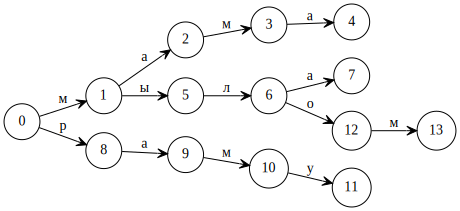

In [10]:
trie = make_trie(words)
to_graph(trie).Visualize()

В терминах конечных автоматов процедура получения этого дерева из простого, изображенного ранее -- это детерминизация. В случае набора слов эта процедура довольно тривиально и её проще поддерживать по мере добавления слова, в процедуре add_word мы сначала пройдем некоторую часть слова, которая уже есть в дереве, а потом создадим ответвление специально под добавляемое слово. В общем случае (регулярные языки) ипользуется специальный алгоритм  построение [супермножества](https://en.wikipedia.org/wiki/Powerset_construction). Так или иначе, преффиксное дерево обладает ключевым свойством: из одного состояния не может быть 2 и более переходов, помеченных одинаковым символом. Это свойство позволяет делать эффективный поиск по дереву

In [11]:
# Для визуализации
def init(graph):
    graph.nodes[0].SetColor('blue')

def step_forward(graph, node, letter):
    node.SetColor('green')
    for arc in node.arcs:
        if arc.weight == letter:
            arc.SetColor('green')
            break
    graph.nodes[arc.end].SetColor('blue')

def fail(graph):
    for node in graph.nodes.values():
        if node.attributes['color'] != 'black':
            node.SetColor('red')
        for arc in node.arcs:
            if arc.attributes['color'] != 'black':
                arc.SetColor('red')
                
def finish_find(node):
    node.SetColor('green')
                
def reset(graph):
    for node in graph.nodes.values():
        node.SetColor('black')
        for arc in node.arcs:
            arc.SetColor('black')
    
######################################

def find(trie, word):
    graph = to_graph(trie)
    init(graph)
    slices = [graph.Visualize()]
    
    state = 0
    for letter in word:
        if letter in trie[state].children:
            step_forward(graph, graph.nodes[state], letter)
            slices.append(graph.Visualize())
            ###
            state = trie[state].children[letter]            
        else:
            fail(graph)
            slices.append(graph.Visualize())
            reset(graph)
            return (False, slices)
        
    if trie[state].word != word:
        fail(graph)
        slices.append(graph.Visualize())
        reset(graph)
        return(False, slices)
    finish_find(graph.nodes[state])
    slices.append(graph.Visualize())
    reset(graph)
    return (True, slices)

In [12]:
result, slices = find(trie, 'мам')
print(result)
animate_list(slices);

False


A Jupyter Widget

Здесь стоит отметить, что при поиске следующей вершины нужно каким-то образом искать ребро по соответствующей букве. Это возвращает нас к хэш таблицам и бинарным деревьям поиска. Стоит отметить, однако, что набор символом заранее известен и ограничен, что довольно сильно облегчает задачу поиска. В итоге поиск строки разбивается на несколько последовательных поисков символов в небольших таблицах, кроме того в случае отстутствия искомого слова в дереве мы просматриваем строку не целиком а только ту часть, которая в дереве содержится. В случае с хеш таблицей мы делаем подсчет хеша -- обычно это линейный проход по строке, -- один запрос поиска по хешу и финальное честное сравнение строк в случае совпадения хешей.

# Алгоритм Ахо-Корасик
Основная задача, которую решает этот алгоритм: "дан набор слов и строка. Нужно в строке найти все вхождения слов из словаря". Важно то, что строка -- это не текст, который разбивается на слова, нужно искать именно как подстроки. Самый простой способ решить эту задачу -- по очереди пытаться найти каждое из слов, пытаясь сопоставить слово всем подстраком нужной длины

In [13]:
search_words = ['ма', 'ам', 'рама']
sentence = 'мама мыла раму'

In [14]:
def find_substrings_simple(words, sentence):
    result = dict()
    comparison_count = 0
    n = len(sentence)
    for word in words:
        # Сюда будем складывать интервалы, соответствующие подстрокам равным word
        intervals = []
        for i in range(n - len(word) + 1):
            match = True
            for j, letter in enumerate(word):
                comparison_count += 1
                if letter != sentence[i + j]:
                    match = False
                    break
            if match:
                intervals.append((i, i + len(word)))
        result[word] = intervals
    return (result, comparison_count)                

In [15]:
result, comparison_count = find_substrings_simple(search_words, sentence)
print('Number of character comparisons:', comparison_count)
for word, intervals in result.items():
    print(word, end=':')
    print(', '.join(map(str, intervals)))

Number of character comparisons: 48
ма:(0, 2), (2, 4)
ам:(1, 3), (11, 13)
рама:


Представления множества в виде прифексного дерева уже сильно помогает ускорить этот базовый подход. Если немного перегруппировать проверки в базовом подходе (поменять местами два внешних цикла), то получается, что мы по очереди для каждой позиции пытаемся проверить, не соответствует ли подстроки, начинающиеся в этой позиции искомым словам? Эту группу проверок можно сделать гораздо быстее с помощью преффиксного дерева, достаточно использовать процедуру на подобие той, что мы делали для поиска

In [24]:
def match_at_position(trie, sentence, position):
    slices = []
    graph = to_graph(trie)
    init(graph)
    slices.append(graph.Visualize())
    state = 0
    matched_words = []
    comparisons = 0
    for i in range(position, len(sentence)):
        comparisons += 1
        if sentence[i] in trie[state].children:
            step_forward(graph, graph.nodes[state], sentence[i])
            slices.append(graph.Visualize())
            
            state = trie[state].children[sentence[i]]
        else:
            fail(graph)
            slices.append(graph.Visualize())
            break
        
        if trie[state].word is not None:
            matched_words.append(trie[state].word)
            
    return (matched_words, slices, comparisons)

def match_suffix(trie, sentence):
    return match_at_position(trie, sentence, position=0)

In [25]:
def find_substrings_trie(words, sentence):
    trie = make_trie(words)

In [29]:
suffixes = [sentence[i:] for i in range(len(sentence))]

visualization_result = {}
result = {}

comparison_total = 0
for i, suffix in enumerate(suffixes):
    matched_words, slices, comparisons_pos = match_suffix(search_trie, suffix)
    comparison_total += comparisons_pos
    for word in matched_words:
        if word not in result:
            result[word] = []
        result[word].append((i, i + len(word)))
    visualization_result[suffix] = slices
    
print('Number of character comparisons:', comparison_total)
for word, intervals in result.items():
    print(word, end=':')
    print(', '.join(map(str, intervals)))

Number of character comparisons: 29
ма:(0, 2), (2, 4)
ам:(1, 3), (11, 13)


In [30]:
animate_dict(visualization_result, 'Суффикс');

A Jupyter Widget

Что более важно, в этом подходе возможно использовать сравнения, которые были сделаны на предыдущих суффиксах, чтобы аккуратно к этому прейти стоит сначала разобрать случай, когда мы ищем только одно слово

## Преффикс функция
Одной из ключевых концепций, ведущих к эффективным алгоритмам поиска подстрок, является <i><b>преффикс-функция</b></i>. Для строки $S=[S_0, S_1, \ldots, S_{n-1}]$ преффкс-функция $P$ определяется как
$$
P[i]=\max\{~j~|~j\leq i,~S[0:j]=S[i-j+1:i+1]~\}
$$
Иначе говоря $P[i]$ -- это максимальная длина нетривиального суффикса, который совпадает с преффиксом. Например для строки `abacaba` преффикс функция выглядит следующим образом
$$
abacaba
$$
$$
0010123
$$
Если мы каким-то образом смогли вычислить преффикс-функцию, то с её помощью мы можем довольно легко без дополнительных сравнений получить все суффиксы, совпадающие с преффиксами, причем в убывающем порядке. По определенияю $P[i]$
$$
S[0:P[i]]=S[i-P[i]+1:i+1]
$$
Учитывая посмотрим на преффикс-функцию в позиции $P[i]-1$:
$$
S[0:P[P[i]-1]]=S[P[i]-P[P[i]-1]:P[i]]=S[i-P[P[i]-1]+1:i+1]
$$
Первое равенство выполняется в силу $P[P[i]-1]$, второе -- в силу $P[i]$. Вот пример на строке `abacaba`: $P[6]=3$, т.е. $S[0:3]=S[4:7]$. При этом $P[2]=1$, что указывает на то, что $S[0:1]=S[6:7]$. Ключевой момент здесь заключается в том, что $P[P[i]-1]$ дает нам наибольший префикс, совпадающиий с суффиксом для $P[i]-1$, а значит также указывает на следующий по возрастанию. Таким образом длины всех возможных совпадающих преффиксов-суффиксов в позиции $i$ -- это $P[i]\rightarrow P[P[i]-1] \rightarrow P[P[P[i]-1]-1]\rightarrow \ldots$.

У преффикс-функции есть еще одно очень простое свойство
$$
P[i]\leq P[i-1]+1.
$$
Следует это из очень простого факта
$$
S[0:P[i]]=S[i-P[i]+1:i+1]\Rightarrow S[0:P[i]-1]=S[i-P[i]+1:i]
$$
Этих двух свойств достаточно, чтобы эффективно вычислить преффикс функцию слева направо наподобие динамическому программированию: если мы посчитали $P$ для $0\ldots i$, то для подсчета $P[i+1]$ нужно взять максимальный совпадающий с суффиксом преффикс для $i$ такой, что следующий за ним символ совпадает с $S[i+1]$. При этом мы умеем перебирать совпадающие преффиксы-суффиксы в убывающем по длине порядке, поэтому первый, который нам попадется с совпадением следующего символа -- это нужный нам преффикс.

In [36]:
def preffix_function(s):
    p = [0]
    k = 0
    for letter in s[1:]:
        while k > 0 and s[k] != letter:
            k = p[k - 1]
        if s[k] == letter:
            k += 1
        p.append(k)
    return p

In [39]:
s = 'abacabadabababa'
print(s)
print(''.join(map(str, preffix_function(s))))

abacabadabababa
001012301232323


### Анализ скорости работы
Несмотря на вложенный цикл оказывается, что эта процедура линейна по количеству символов в `s`. Дело в том, что `k` может увеличиваться на каждой итерации внешнего цикла не более, чем на единицу в строке (в условном операторе), а уменьшаться только при `k = p[k - 1]`. Из этого следует, что количество итераций внутреннего цикла суммарно не превосходит длину строки.